In [1]:
"""
The structure of this file is the following
This file must be placed in a folder that contains the 
1.) the .csv of the targeted inclusion list
2.) and the mzML of the targeted run that used that inclusion list
In the parent directory, there must be a folder called "Scout" that contains the Scout runs (3v3)
"""

'\nThe structure of this file is the following\nThis file must be placed in a folder that contains the \n1.) the .csv of the targeted inclusion list\n2.) and the mzML of the targeted run that used that inclusion list\nIn the parent directory, there must be a folder called "Scout" that contains the Scout runs (3v3)\n'

In [2]:
import os
import math
import pandas as pd
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pyopenms import *
import numpy as np

In [3]:
def find_nearest_tol(array, value, tol):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if (np.abs(array[idx] - value)).min() > tol:
        return -1,-1
    else:
        return array[idx],idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [4]:
savedir = os.path.join(os.getcwd(),"EICs")
smallsavedir = os.path.join(os.getcwd(),"EICs","Small")
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(smallsavedir):
    os.makedirs(smallsavedir)
    
excel_name = 'EICs of 12ca5 vs MDM2 CX12CK'

In [5]:
parent = os.path.dirname(os.getcwd())
scout_file_loc = os.path.join(parent,"Scout")

In [6]:
scout_list = sorted(os.listdir(scout_file_loc))

In [8]:
scout_files = []
for scout_name in scout_list:
    scout_files.append(os.path.join(scout_file_loc,scout_name))
#print(scout_files)

In [9]:
target_mzML = []
for file in os.listdir(os.getcwd()):
    if file.endswith('.mzML'):
        target_mzML.append(file)

In [10]:
combined_files = scout_files+target_mzML

['/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/12ca5-Alq6-Repl1-Scout-1.mzML', '/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/12ca5-Alq6-Repl1-Scout-2.mzML', '/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/12ca5-Alq6-Repl1-Scout-3.mzML', '/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/MDM2-Alq6-Repl1-Scout-1.mzML', '/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/MDM2-Alq6-Repl1-Scout-2.mzML', '/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/MDM2-Alq6-Repl1-Scout-3.mzML', 'Targ-12ca5-Alq6-1-PEAKS-E-Score.mzML']


In [11]:
graph_list = scout_list + [os.path.split(target_mzML[0])[1]]
graph_names = [x[:-5] for x in graph_list]

In [12]:
directory = os.getcwd()
RTs_full = []
ints_full = []
mzs_full = []
names = []
for file in combined_files:
    if file.endswith('.mzML'):
        print(file)
        names.append(file[:-5])
        exp = MSExperiment()
        MzMLFile().load(os.path.join(directory,file),exp)
        RT_list_rep = []
        int_list_rep = []
        RTs = []
        mzs = []
        ints = []
        for spec in exp:
            RTs.append(spec.getRT())
            mzs_scan, ints_scan = spec.get_peaks()  
            mzs.append(mzs_scan)
            ints.append(ints_scan)
        RTs_full.append(RTs)
        ints_full.append(ints)
        mzs_full.append(mzs)    

/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/12ca5-Alq6-Repl1-Scout-1.mzML
/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/12ca5-Alq6-Repl1-Scout-2.mzML
/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/12ca5-Alq6-Repl1-Scout-3.mzML
/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/MDM2-Alq6-Repl1-Scout-1.mzML
/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/MDM2-Alq6-Repl1-Scout-2.mzML
/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/Scout/MDM2-Alq6-Repl1-Scout-3.mzML
Targ-12ca5-Alq6-1-PEAKS-E-Score.mzML


In [13]:
target_mz_file = []
for file in os.listdir(os.getcwd()):
    if file.endswith('.csv'):
        target_mz_file.append(file)

In [14]:
target_file = pd.read_csv(target_mz_file[0])
target_file = target_file.fillna(' ')

In [15]:
m_z_list = target_file['m/z'].tolist()
tstart_list = target_file['t start (min)'].tolist()
tend_list = target_file['t stop (min)'].tolist()
feature_RT = [round(((start + stop) / 2)*60,2) for start, stop in zip(tstart_list, tend_list)]

In [16]:
RT_orig_list = [np.zeros(7) for i in m_z_list]
score_list = np.zeros(len(m_z_list))
p_scores = np.zeros(len(m_z_list))
time = 20
peak_range=30
decimal = 2
baseline = 1

In [17]:
os.path.join(savedir,f'EICs of {target_mz_file[0][:-4]}.xlsx')

'/home/gridsan/jbrown/pyBinder/284-188_Scout_vs_Targ_12ca5_Alq6_Repl1/PEAKS-E-Score/EICs/EICs of 12ca5 Alq 6 PEAKS E-Score Mass Adj.xlsx'

In [18]:
# This block basically copies a target_file.csv into an editable Excel
workbook = xlsxwriter.Workbook(os.path.join(savedir,name))
worksheet = workbook.add_worksheet()
for i,col in enumerate(target_file.columns):
    column_name = xlsxwriter.utility.xl_col_to_name(i)
    listing = target_file[col].tolist()
    for j,element in enumerate(listing):
        if j == 0:
            worksheet.write(column_name+str(j+1),target_file.columns[i])
        worksheet.write(column_name+str(j+2),element)

832.5050942


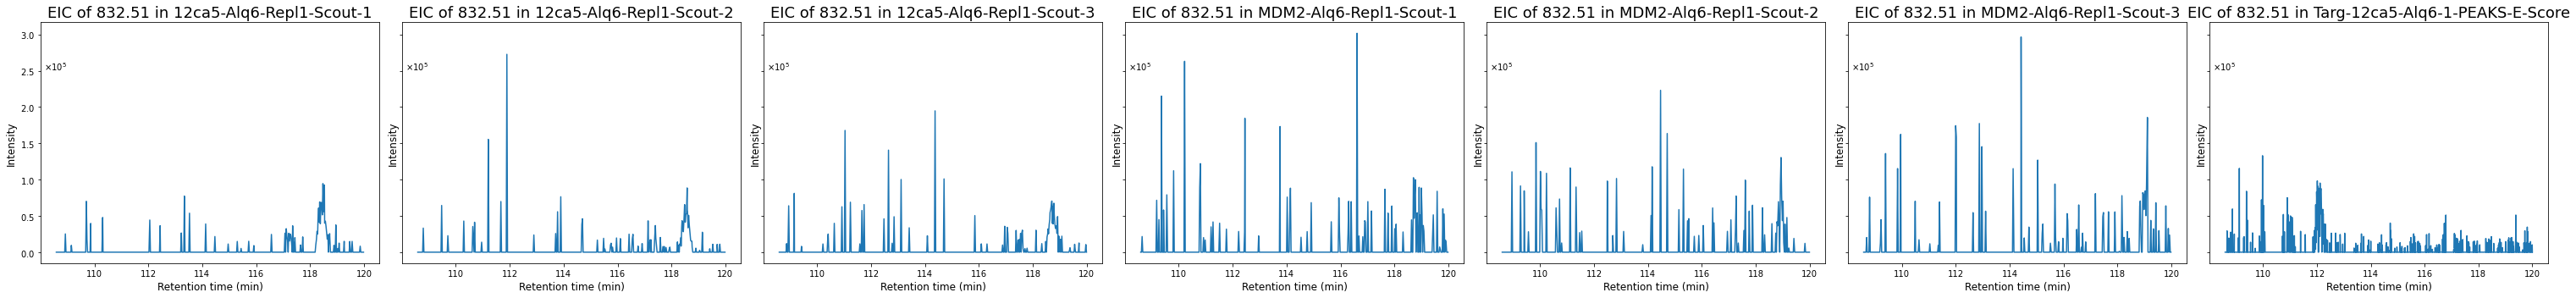

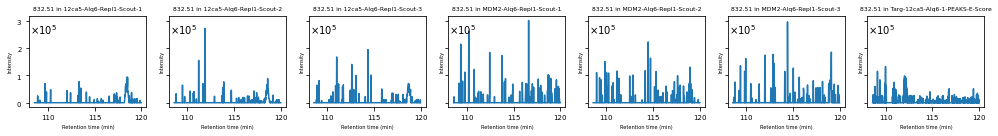

840.4435094


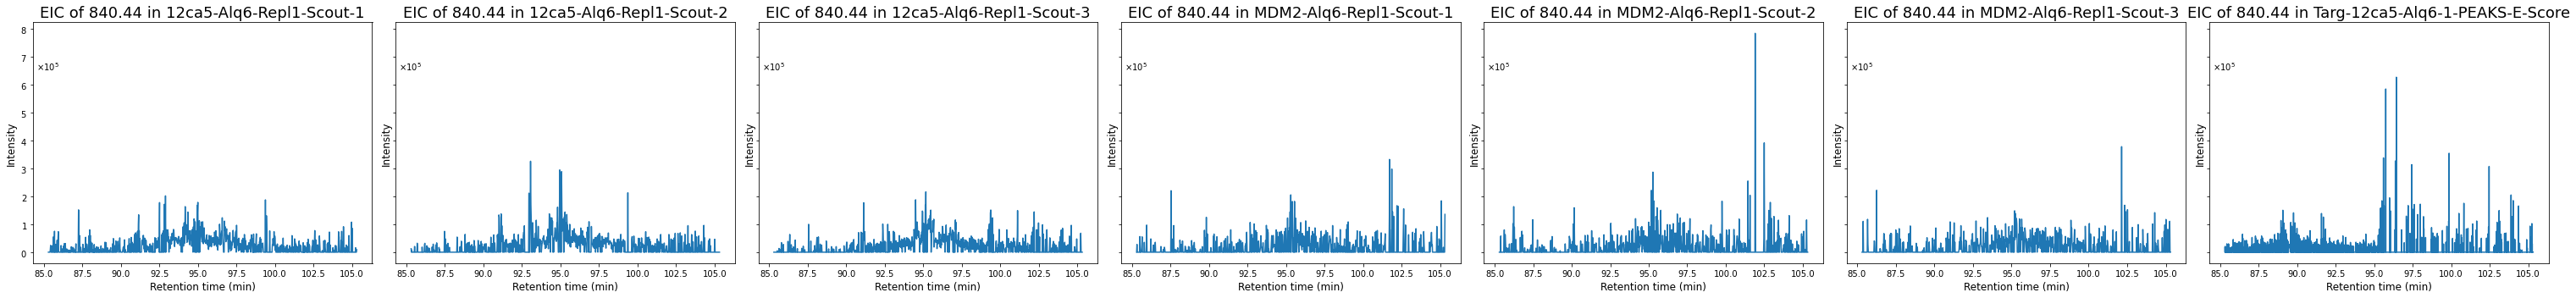

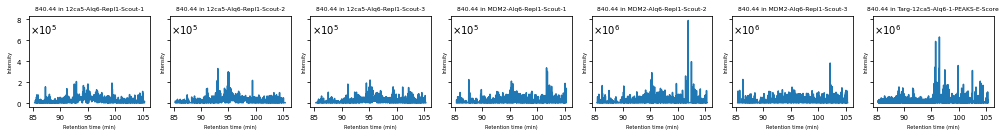

840.4498095


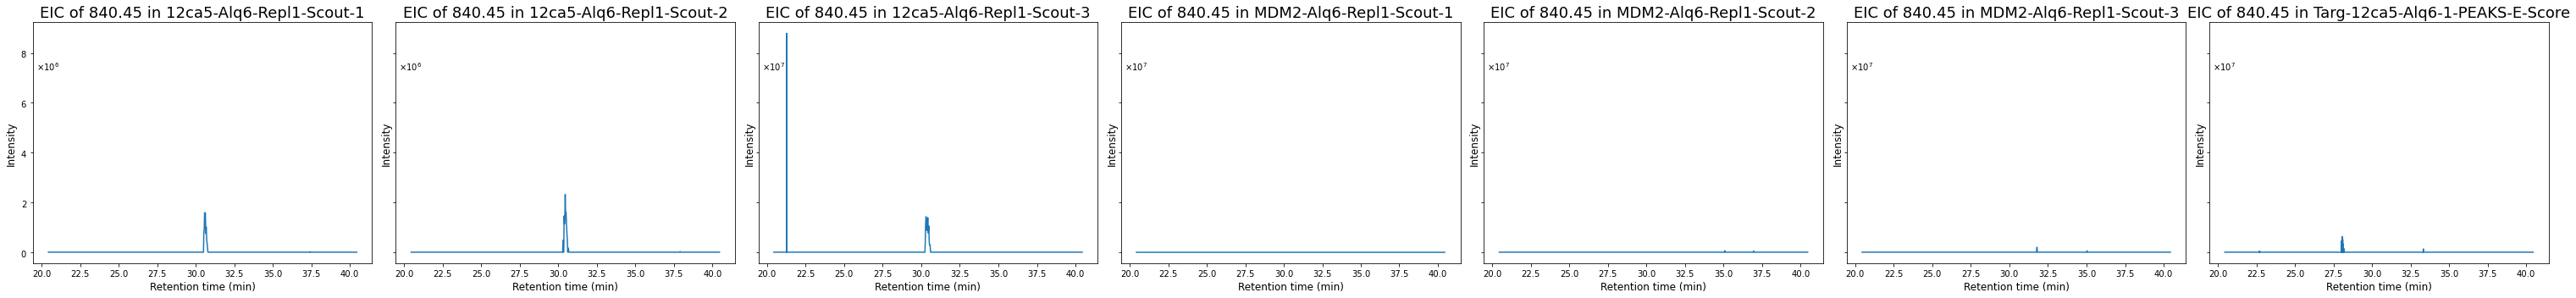

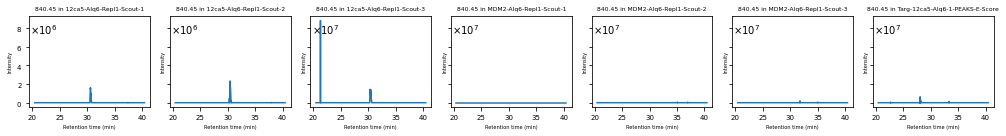

841.1518108


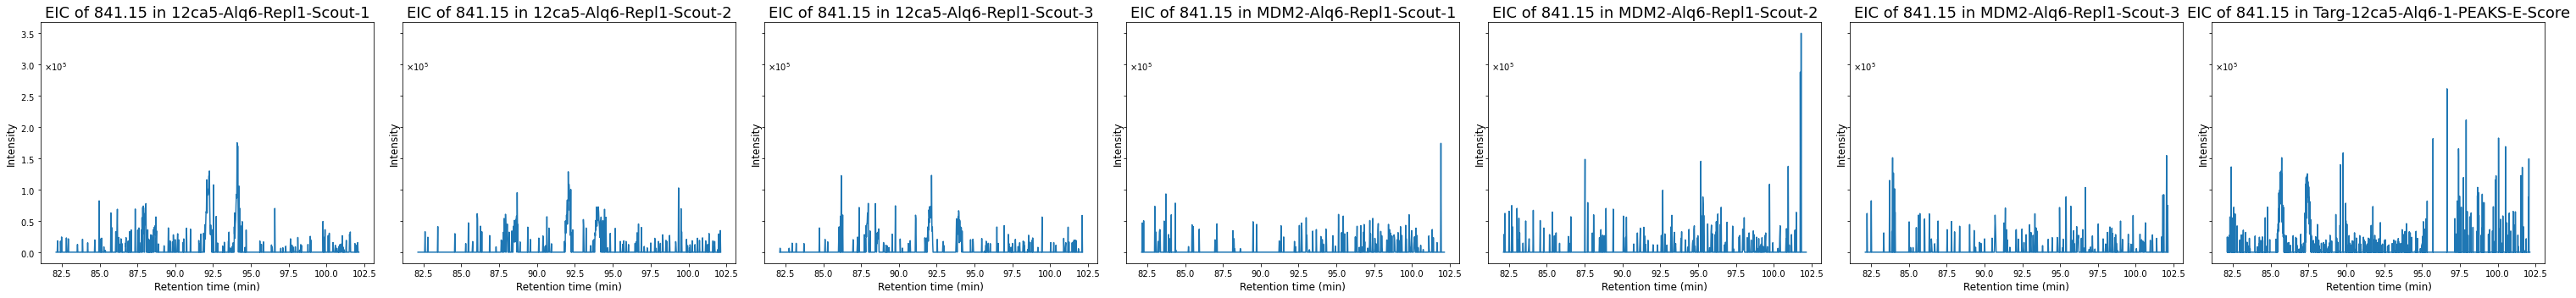

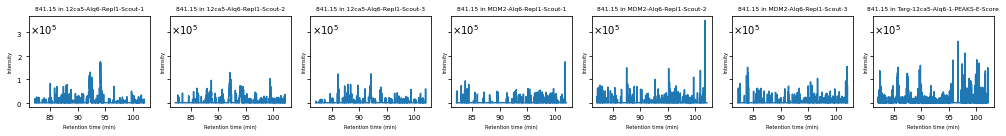

421.7371076


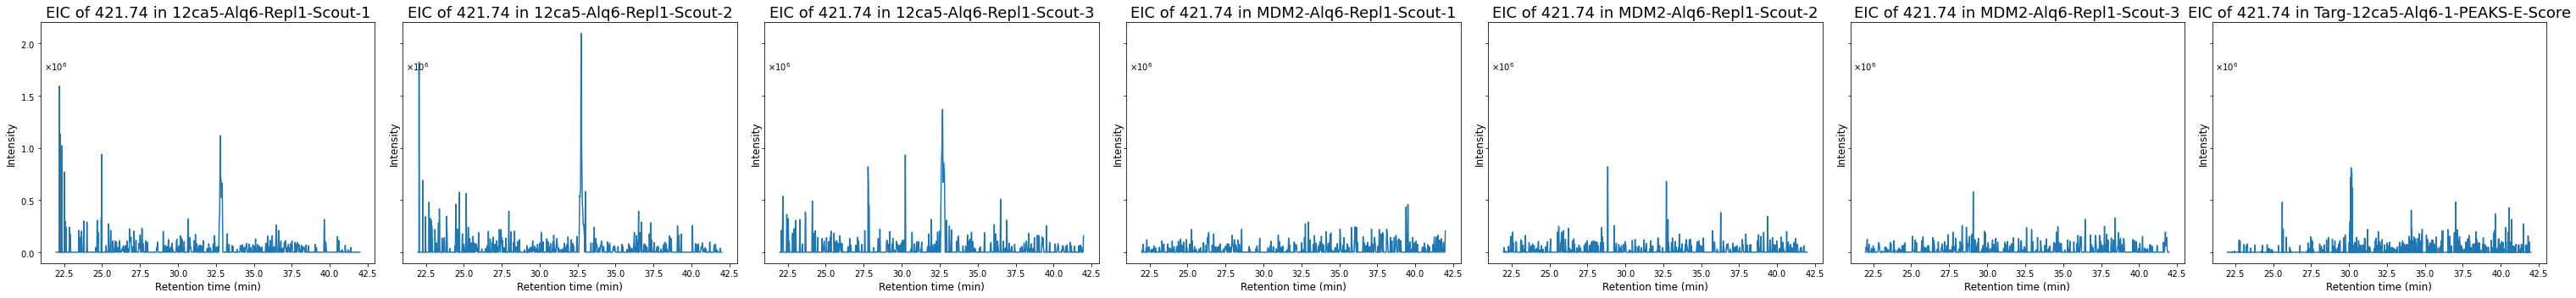

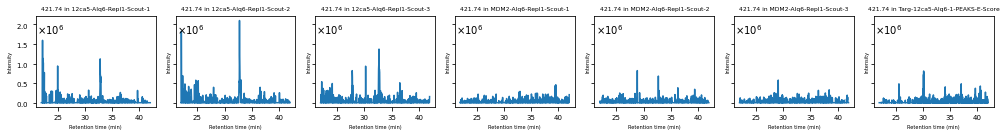

846.4413209


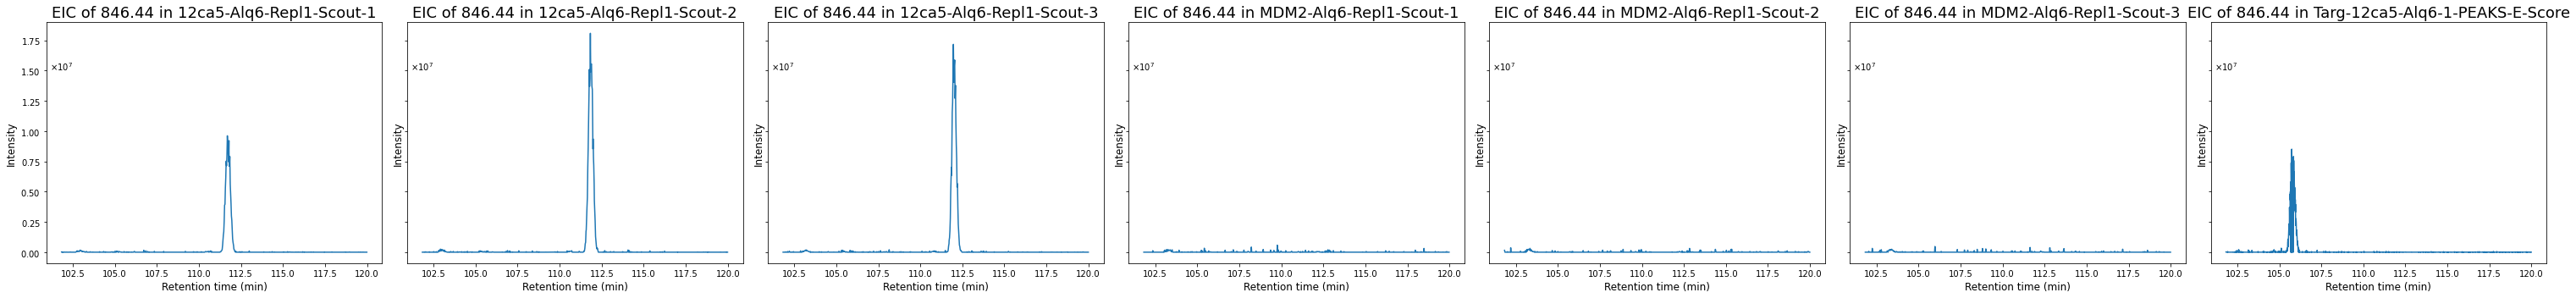

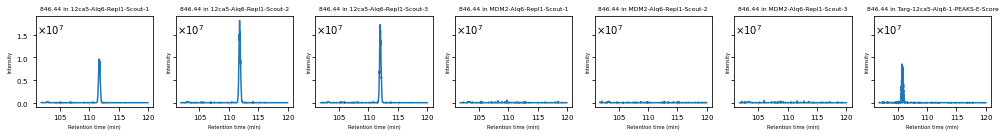

851.3958304


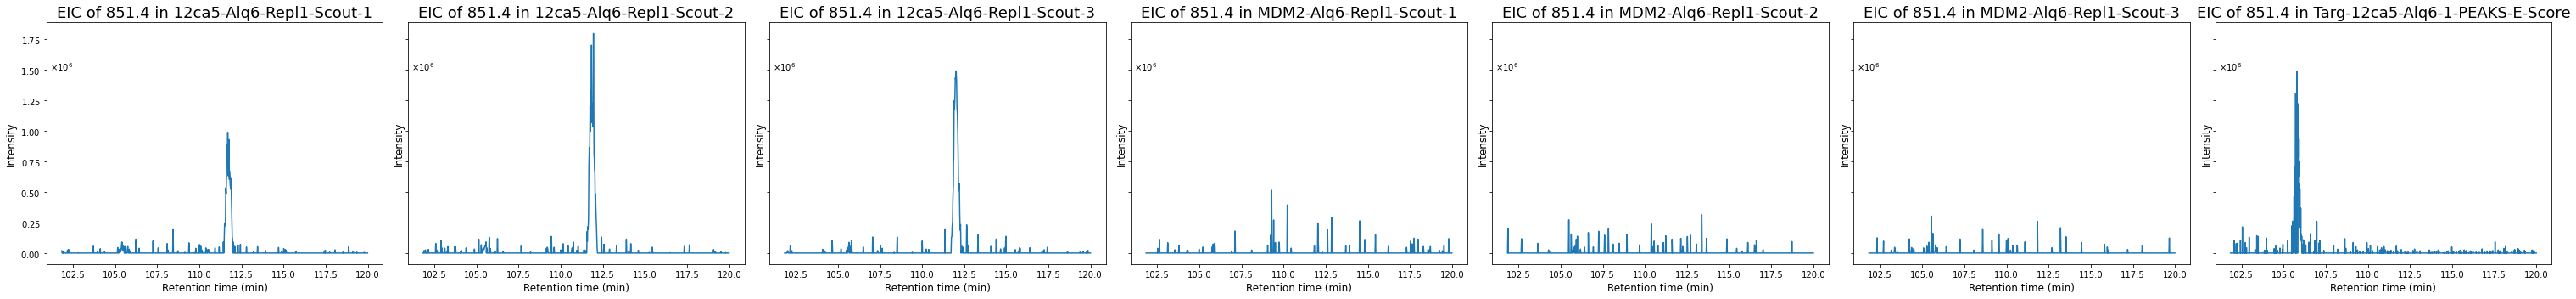

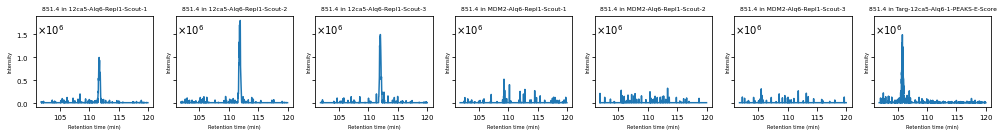

426.6061169


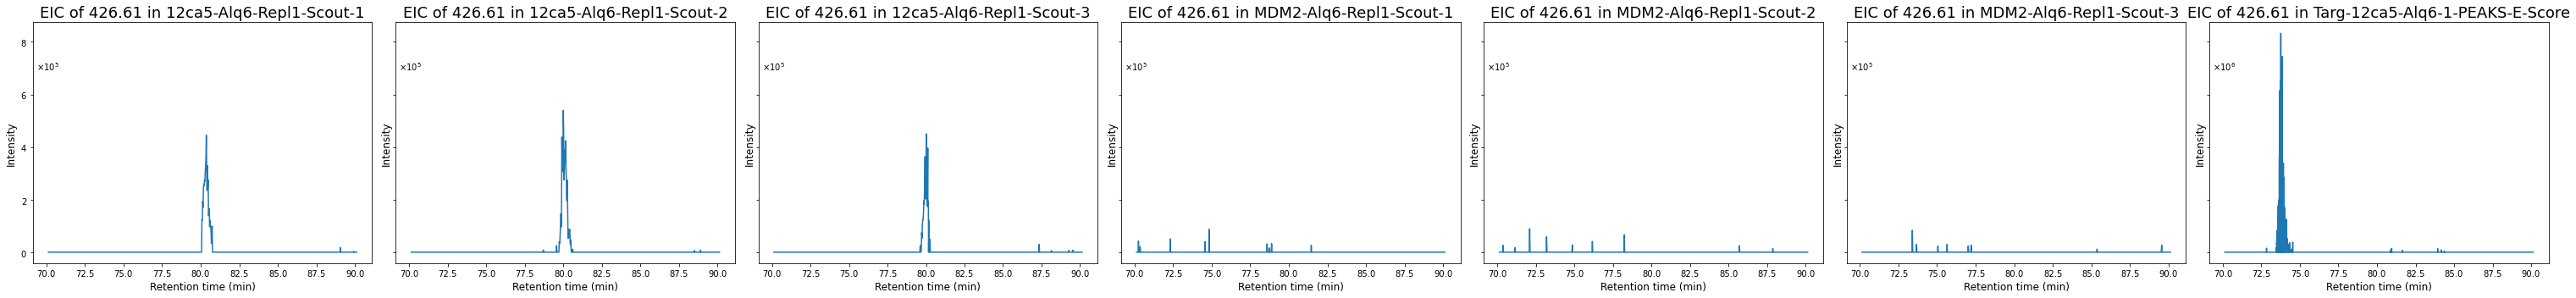

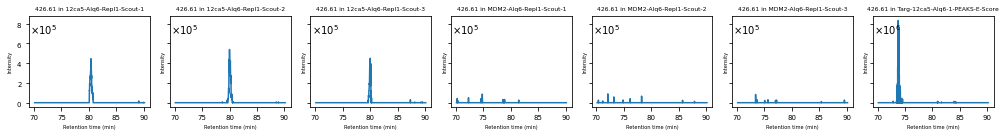

In [19]:
for j,mz in enumerate(m_z_list):       # loop through each feature
    print(mz)
    RT_feature = feature_RT[j]
    RT_origs = RT_orig_list[j]
    e_score = score_list[j]
    p_val = p_scores[j]
    xs = []
    xs_zoom = []
    ys = []
    max_array = []
    for k in range(len(RTs_full)):             # loop through each replicate
        RTs_rep = RTs_full[k]
        RT_orig = RT_origs[k]
        if RT_orig == 0:
            RT_orig = RT_feature
        ints_rep = ints_full[k]
        mzs_rep = mzs_full[k]

        RT_idx_low = find_nearest(RTs_rep,RT_orig-time/2*60)[1]
        RT_idx_high = find_nearest(RTs_rep,RT_orig+time/2*60)[1] 

        RTs_slice = RTs_rep[RT_idx_low:RT_idx_high+1]

        max_idx_low = find_nearest(RTs_slice,RT_orig-peak_range/2)[1]
        max_idx_high = find_nearest(RTs_slice,RT_orig+peak_range/2)[1]

        ints_slice = ints_rep[RT_idx_low:RT_idx_high+1]    # should take a slice of arrays for both of these
        mzs_slice = mzs_rep[RT_idx_low:RT_idx_high+1]
        mz_idx = [find_nearest_tol(entry,mz,10**(-decimal)/2)[1] for entry in mzs_slice] # find idx where the feature mz is in each scan

        ints_EIC = [array[mz_idx[o]] if mz_idx[o] > 0 else baseline for o,array in enumerate(ints_slice)]

        try:
            max_found = np.amax(ints_EIC[max_idx_low:max_idx_high])
        except ValueError:
            max_found = np.amax(ints_EIC)
            #print(ints_EIC[max_idx_low:max_idx_high],ints_EIC)
        max_array.append(max_found)
        xs.append(RTs_slice)
        xs_zoom.append(RTs_slice[max_idx_low:max_idx_high])
        ys.append(ints_EIC)

    #create the EIC as a regular figure to be saved and *probabaly* never looked at
    fig, axs = plt.subplots(1,int(len(names)),figsize=(6*len(names),5),sharey=True)
    for l in range(int(len(names))):
        x = [t/60 for t in xs[l]]
        y = ys[l]
        axs[l].plot(x,y)
        axs[l].set_title(f"EIC of {np.round(mz,decimal)} in {graph_names[l]}",fontsize=18)
        axs[l].set_xlabel('Retention time (min)',fontsize=12)
        axs[l].set_ylabel('Intensity',fontsize=12)
        yfmt = mticker.ScalarFormatter(useMathText=True)
        yfmt.set_powerlimits((3, 4))
        axs[l].yaxis.set_major_formatter(yfmt)
        axs[l].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axs[l].get_yaxis().get_offset_text().set_visible(False)
        ax_max = max(axs[l].get_yticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        axs[l].annotate(r'$\times$10$^{%i}$'%(exponent_axis),
                     xy=(.01, .8), xycoords='axes fraction')
    plt.tight_layout()
    figname = f'EIC of mz of {np.round(mz,decimal)} at {np.round(RT_feature/60,1)}.png'
    plt.savefig(os.path.join(savedir,figname),dpi = 150)
    plt.show()

    #create the EIC as a small figure to be inserted into the Excel
    fig, axs = plt.subplots(1,int(len(names)),figsize=(2*len(names),2),sharey=True)
    for l in range(int(len(names))):
        x = [t/60 for t in xs[l]]
        y = ys[l]
        axs[l].plot(x,y)
        axs[l].set_title(f"{np.round(mz,decimal)} in {graph_names[l]}",fontsize=6)
        axs[l].set_xlabel('Retention time (min)',fontsize=5)
        axs[l].set_ylabel('Intensity',fontsize=5)
        yfmt = mticker.ScalarFormatter(useMathText=True)
        yfmt.set_powerlimits((3, 4))
        axs[l].yaxis.set_major_formatter(yfmt)
        axs[l].tick_params(axis='both', which='major', labelsize=7)
        axs[l].get_yaxis().get_offset_text().set_visible(False)
        ax_max = max(axs[l].get_yticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        axs[l].annotate(r'$\times$10$^{%i}$'%(exponent_axis),
                     xy=(.01, .8), xycoords='axes fraction')
    plt.tight_layout()
    fignamesmall = f'EIC of mz of {np.round(mz,decimal)} at {np.round(RT_feature/60,1)} small.png'
    plt.savefig(os.path.join(smallsavedir,fignamesmall),dpi = 150)
    plt.show()
    
    # Insert into Excel, after making the row bigger
    worksheet.set_row(j+1,150)
    worksheet.insert_image('H'+str(j+2),os.path.join(smallsavedir,fignamesmall),{'x_offset': 2, 'y_offset': 2})

    if j == 7:
        workbook.close()
        break

## Testing below

In [20]:
# if do_EICs:
#     for i,score in enumerate(es_graphing):
#         score_sorted = np.sort(score)[::-1]
#         indices_sorted = np.argsort(score)[::-1]
#         count = 0
#         mzs = []
#         RTs = []
#         RTs_orig = []
#         scores = []
#         p_to_graph = []
#         while score_sorted[count] >= enr_score_cutoff and len(scores) < nr_EICs:
#             index = indices_sorted[count]
#             mzs.append(mzs_graphing[i][index])
#             RTs.append(RTs_graphing[i][index])
#             RTs_orig.append(RTs_graphing_orig[i][index])
#             scores.append(score_sorted[count])
#             p_to_graph.append(ps_graphing[i][index][0])
#             count -= -1
#             if count >= len(score):
#                 break
#         plot_EIC_alternate_zoom(mzs,RTs,RTs_orig,scores,p_to_graph,data_dir,eic_dirs_spec[i],baseline=0,peak_range=peak_RT)
        
#     if es_nonspecific:
#         for i in range(len(prots)):
#             score = [entry[i] for entry in es_nonspecific]
#             score_sorted = np.sort(score)[::-1]
#             indices_sorted = np.argsort(score)[::-1]
#             count = 0
#             mzs = []
#             RTs = []
#             RTs_orig = []
#             scores = []
#             p_to_graph = []
#             while score_sorted[count] >= enr_score_cutoff and len(scores) < nr_EICs:
#                 index = indices_sorted[count]
#                 mzs.append(mzs_nonspecific[index])
#                 RTs.append(RTs_nonspecific[index])
#                 RTs_orig.append(RTs_nonspecific_orig[index])
#                 scores.append(score_sorted[count])
#                 p_to_graph.append(ps_nonspecific[index][0])
#                 count -= -1
#                 if count >= len(score):
#                     break
#             plot_EIC_alternate_zoom(mzs,RTs,RTs_orig,scores,p_to_graph,data_dir,eic_dirs_nonspec[i],baseline=0,peak_range=peak_RT)
            
#     for i in range(len(prots)):
#         score = [entry[i] for entry in es_unclear]
#         score_sorted = np.sort(score)[::-1]
#         indices_sorted = np.argsort(score)[::-1]
#         count = 0
#         mzs = []
#         RTs = []
#         RTs_orig = []
#         scores = []
#         p_to_graph = []
#         while score_sorted[count] >= enr_score_cutoff and len(scores) < nr_EICs:
#             index = indices_sorted[count]
#             mzs.append(mzs_unclear[index])
#             RTs.append(RTs_unclear[index])
#             RTs_orig.append(RTs_unclear_orig[index])
#             scores.append(score_sorted[count])
#             p_to_graph.append(ps_unclear[index][0])
#             count -= -1
#             if count >= len(score):
#                 break
#         plot_EIC_alternate_zoom(mzs,RTs,RTs_orig,scores,p_to_graph,data_dir,eic_dirs_other[i],baseline=0,peak_range=peak_RT)

In [21]:
 #def plot_EIC_alternate_zoom(m_z_list,feature_RT,RT_orig_list,score_list,p_scores,directory,savedir,time=5,peak_range=30,decimal=2,reps=3,baseline=0):
    # plot_EIC_alternate_zoom(mzs,RTs,RTs_orig,scores,p_to_graph,data_dir,eic_dirs_spec[i],time=10,baseline=0,peak_range=peak_RT)
     # mzs = [371.11, etc] #consensus features
     # RTs = [69, 420, etc] #consensus features in seconds
     # RTs_orig this is before alignment, from each feature map, if nonexistant, provide a [0, 0, etc] as a placeholder
     # scores [0,0,69,]
     # p_to_graph [0] jk just an array i forgot i unpacked it when making the inputs
     # data_dir mzMLs are here
     # eic_dirs_spec[i] i is from the protein, just put in a directory
     # time in minutes +/-
     # baseline=0 # could be 0 today or 15000 tomorrow
     # peak_range=peak_RT currently set to 120